In [1]:
# import glm_utils
import glm_utils.preprocessing, glm_utils.bases
import matplotlib.pyplot as plt
import numpy as np
import sklearn.model_selection, sklearn.metrics, sklearn.linear_model
from scipy.stats import zscore, binned_statistic, pearsonr
import os
import pickle
import pandas as pd
import itertools as itt
import seaborn as sns
from DN_tools import load_into_pandas, bases_dict, load_recording, get_xy, lp, chunked_test_train_split, plot_glm_filter
from tqdm import tqdm


plt.style.use("W:/apalaci/code/janache/DNpaper.mplstyle")

In [2]:
raw_data_dir_path = 'W:/apalaci/code/janache'
results_dir_path = 'W:/apalaci/code/janache/res'
sample_frequency = 20000
isplit = 0
redo_analysis = False
bin_width = 100; decimating_values = [10,10]

cutoff = 20
block_size = 5_000; n_block_min=5; test_size = 0.35; random_state = 42; starting_nbins = 32
window = bases_dict['window']

df = load_into_pandas(dir_path=raw_data_dir_path)
df = df[(df.to_ignore == False)&(df.DN != "Roadrunner")].reset_index(drop=True)

In [3]:
def get_residuals(y_m):
    residuals = np.zeros_like(y_m)
    for iv in range(y_m.shape[1]):
        lr_temp = sklearn.linear_model.Ridge(max_iter=20000)
        lr_temp.fit(y_m[:,[1-iv]], y_m[:,iv])
        y_pred_temp = lr_temp.predict(y_m[:,[1-iv]])
        residuals[:,iv] = y_m[:,iv] - y_pred_temp
    return residuals

In [6]:
if redo_analysis:
    B = glm_utils.bases.raised_cosine(neye = bases_dict['neye'], ncos = bases_dict['ncos'], kpeaks = bases_dict['kpeaks'], b = bases_dict['b'], nbasis = bases_dict['nbasis'])
    B = B[-window:]
    basis_projection = glm_utils.preprocessing.BasisProjection(B)

    for y_names in (["v_fwd","abs_v_ang"], ["abs_v_fwd","abs_v_ang"]):

        datefolder = f'{results_dir_path}/2025_glms_regressed_{y_names[0]}'

        for index, row in tqdm(df.iterrows(), total=len(df)):
            filename = row['filename']
            csv_path = row['abs_file_path']

            singleDN_df = load_recording(csv_path=csv_path)

            x, ys = get_xy(singleDN_df,y_names)

            y_means = np.mean(ys, axis=0)
            y_stds = np.std(ys, axis=0)
            y_zscored = zscore(ys, axis=0)

            X, y_m_original = glm_utils.preprocessing.time_delay_embedding(x, ys, window_size=window, flatten_inside_window=True, exclude_t0=True)
            X_b = basis_projection.transform(X)
            # y_m = lp(y_m, cutoff=cutoff, fs=int(sample_frequency/bin_width))
            y_m = get_residuals(y_m_original)

            X_train, X_test, y_train, y_test = chunked_test_train_split(X_b,y_m,block_size=block_size,n_block_min=n_block_min,test_size=test_size,random_state=random_state)

            for iv, varname in enumerate(y_names):
                if (y_means[iv] == 0) and (y_stds[iv] == 0):
                    print(f"{filename}, {varname} - y has constant or NaN values")
                else:
                    # Fit
                    lr = sklearn.linear_model.LassoCV(max_iter=20000)
                    lr.fit(X_train, y_train[:,iv])

                    # Predictions
                    y_pred = lr.predict(X_train)
                    y_pred_test = lr.predict(X_test)

                    # Attempt to estimate nonlinearity (last record: ~12% constant value)
                    nbins = starting_nbins
                    not_finished = True
                    while (nbins != 5) and not_finished:
                        bin_edges_quantilebased = np.quantile(y_pred, np.linspace(0, 1, nbins + 1))
                        try:
                            statistic, bin_edges, binnumber = binned_statistic(y_pred, y_train[:,iv], statistic='mean', bins=bin_edges_quantilebased, range=None)
                            bin_centers = bin_edges[:-1] + np.median(np.diff(bin_edges)) / 2
                            constant_input = False
                            not_finished = False
                        except ValueError as e:
                            if str(e) != 'The smallest edge difference is numerically 0.':
                                print("ValueError: ",e)
                            else:
                                nbins -= 1

                    if (nbins == 5) and not_finished:
                        statistic = [np.nanmean(y_train[:,iv])]
                        bin_centers = [np.nanmean(y_pred)]
                        constant_input = True
                    
                    if np.sum(np.isnan(statistic)) > 0:
                        y_pred_test_nl = np.interp(y_pred_test, bin_centers[~np.isnan(statistic)], statistic[~np.isnan(statistic)])
                    else:
                        y_pred_test_nl = np.interp(y_pred_test, bin_centers, statistic)
                    
                    # Scores
                    r2_train = lr.score(X_train, y_train[:,iv])
                    r2_test = lr.score(X_test, y_test[:,iv]) # equivalent to sklearn.metrics.r2_score(y_test,y_pred_test)
                    pearsonr_score_linear = pearsonr(y_pred_test, y_test[:,iv]).statistic
                    if constant_input:
                        r2_nl = 0
                        pearsonr_score = pearsonr_score_linear
                    else:
                        r2_nl = sklearn.metrics.r2_score(y_test[:,iv],y_pred_test_nl)
                        pearsonr_score = pearsonr(y_pred_test_nl, y_test[:,iv]).statistic
                    # print(f"{filename} {varname} - score (linear): {pearsonr_score_linear:1.2f}, score: {pearsonr_score:1.2f}, train: {r2_train:1.2f}, test: {r2_test:1.2f}, nl: {r2_nl:1.2f} - constant {constant_input}, {nbins} bins")

                    # Filter
                    basis_weights = lr.coef_
                    estimated_filters = basis_projection.inverse_transform(basis_weights)
                    estimated_filters = estimated_filters.reshape((-1,window))

                    # Store
                    if not os.path.exists(f'{datefolder}'):
                        os.mkdir(f'{datefolder}')
                    with open(f'{datefolder}/{filename}_{varname}_isplit{isplit}.pkl', 'wb') as handle:
                        pickle.dump({'model':lr,'pearsonr_score_linear':pearsonr_score_linear,'pearsonr_score':pearsonr_score,'r2_train':r2_train,'r2_test':r2_test,'r2_nl':r2_nl,'estimated_filters':estimated_filters,'y_pred_test':y_pred_test,'y_pred_test_nl':y_pred_test_nl,'bin_centers':bin_centers,'statistic':statistic,'y_means':y_means[iv],'y_stds':y_stds[iv],'nsamples':len(x), 'duration':len(x)/int(sample_frequency/bin_width), 'constant_input':constant_input, 'nbins':nbins,'y_train':y_train[:,iv],'y_test':y_test[:,iv],'y_pred_train':y_pred}, handle, protocol=pickle.HIGHEST_PROTOCOL)

  0%|          | 0/70 [00:00<?, ?it/s]C:\Users\apalaci\AppData\Local\Temp\ipykernel_13892\1850568363.py:70: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearsonr_score_linear = pearsonr(y_pred_test, y_test[:,iv]).statistic
 11%|█▏        | 8/70 [02:28<19:34, 18.94s/it]C:\Users\apalaci\AppData\Local\Temp\ipykernel_13892\1850568363.py:70: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearsonr_score_linear = pearsonr(y_pred_test, y_test[:,iv]).statistic
 13%|█▎        | 9/70 [02:35<15:25, 15.17s/it]C:\Users\apalaci\AppData\Local\Temp\ipykernel_13892\1850568363.py:70: NearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  pearsonr_score_linear = pearsonr(y_pred_test, y_test[:,iv]).statistic
 17%|█▋        | 12/70 [02:56<09:32,  9.87s/it]

RECORDING TOO SMALL, NOT CHUNKING


 19%|█▊        | 13/70 [03:03<08:31,  8.98s/it]C:\Users\apalaci\AppData\Local\Temp\ipykernel_13892\1850568363.py:70: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearsonr_score_linear = pearsonr(y_pred_test, y_test[:,iv]).statistic
 39%|███▊      | 27/70 [06:30<09:54, 13.82s/it]C:\Users\apalaci\AppData\Local\Temp\ipykernel_13892\1850568363.py:70: NearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  pearsonr_score_linear = pearsonr(y_pred_test, y_test[:,iv]).statistic
 40%|████      | 28/70 [06:35<07:52, 11.24s/it]

RECORDING TOO SMALL, NOT CHUNKING


 46%|████▌     | 32/70 [08:28<14:03, 22.20s/it]

RECORDING TOO SMALL, NOT CHUNKING


 50%|█████     | 35/70 [08:41<06:22, 10.92s/it]C:\Users\apalaci\AppData\Local\Temp\ipykernel_13892\1850568363.py:70: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearsonr_score_linear = pearsonr(y_pred_test, y_test[:,iv]).statistic
 51%|█████▏    | 36/70 [08:46<05:09,  9.10s/it]C:\Users\apalaci\AppData\Local\Temp\ipykernel_13892\1850568363.py:70: NearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  pearsonr_score_linear = pearsonr(y_pred_test, y_test[:,iv]).statistic
 53%|█████▎    | 37/70 [08:57<05:19,  9.68s/it]C:\Users\apalaci\AppData\Local\Temp\ipykernel_13892\1850568363.py:70: NearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  pearsonr_score_linear = pearsonr(y_pred_test, y_test[:,iv]).statistic
C:\Users\apalaci\AppData\Local\Temp\ipykernel_13892\1850568363.py:70: NearConstantInputWarning: An input 

RECORDING TOO SMALL, NOT CHUNKING


 61%|██████▏   | 43/70 [10:34<07:07, 15.84s/it]C:\Users\apalaci\AppData\Local\Temp\ipykernel_13892\1850568363.py:70: NearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  pearsonr_score_linear = pearsonr(y_pred_test, y_test[:,iv]).statistic
 67%|██████▋   | 47/70 [11:42<06:38, 17.32s/it]C:\Users\apalaci\AppData\Local\Temp\ipykernel_13892\1850568363.py:70: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearsonr_score_linear = pearsonr(y_pred_test, y_test[:,iv]).statistic
C:\Users\apalaci\AppData\Local\Temp\ipykernel_13892\1850568363.py:70: NearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  pearsonr_score_linear = pearsonr(y_pred_test, y_test[:,iv]).statistic
 69%|██████▊   | 48/70 [11:51<05:25, 14.80s/it]C:\Users\apalaci\AppData\Local\Temp\ipykernel_13892\1850568363.py:70: ConstantInputWarning: An input arra

RECORDING TOO SMALL, NOT CHUNKING


 79%|███████▊  | 55/70 [13:23<02:39, 10.65s/it]

RECORDING TOO SMALL, NOT CHUNKING


 83%|████████▎ | 58/70 [13:58<02:17, 11.44s/it]

RECORDING TOO SMALL, NOT CHUNKING


 91%|█████████▏| 64/70 [14:59<01:07, 11.22s/it]

RECORDING TOO SMALL, NOT CHUNKING


 93%|█████████▎| 65/70 [15:01<00:42,  8.42s/it]

RECORDING TOO SMALL, NOT CHUNKING


 94%|█████████▍| 66/70 [15:04<00:27,  6.80s/it]C:\Users\apalaci\AppData\Local\Temp\ipykernel_13892\1850568363.py:70: NearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  pearsonr_score_linear = pearsonr(y_pred_test, y_test[:,iv]).statistic
 96%|█████████▌| 67/70 [15:16<00:25,  8.50s/it]C:\Users\apalaci\AppData\Local\Temp\ipykernel_13892\1850568363.py:70: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearsonr_score_linear = pearsonr(y_pred_test, y_test[:,iv]).statistic
 16%|█▌        | 11/70 [02:32<10:22, 10.55s/it]C:\Users\apalaci\AppData\Local\Temp\ipykernel_13892\1850568363.py:70: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearsonr_score_linear = pearsonr(y_pred_test, y_test[:,iv]).statistic
 17%|█▋        | 12/70 [02:37<08:33,  8.86s/it]

RECORDING TOO SMALL, NOT CHUNKING


 19%|█▊        | 13/70 [02:45<07:59,  8.41s/it]C:\Users\apalaci\AppData\Local\Temp\ipykernel_13892\1850568363.py:70: NearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  pearsonr_score_linear = pearsonr(y_pred_test, y_test[:,iv]).statistic
 20%|██        | 14/70 [02:50<07:05,  7.60s/it]C:\Users\apalaci\AppData\Local\Temp\ipykernel_13892\1850568363.py:70: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearsonr_score_linear = pearsonr(y_pred_test, y_test[:,iv]).statistic
 21%|██▏       | 15/70 [02:55<05:59,  6.54s/it]C:\Users\apalaci\AppData\Local\Temp\ipykernel_13892\1850568363.py:70: NearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  pearsonr_score_linear = pearsonr(y_pred_test, y_test[:,iv]).statistic
 33%|███▎      | 23/70 [05:07<14:04, 17.97s/it]C:\Users\apalaci\AppData\Local\Temp\ipykernel_13892\185056

RECORDING TOO SMALL, NOT CHUNKING


 46%|████▌     | 32/70 [08:02<13:49, 21.82s/it]

RECORDING TOO SMALL, NOT CHUNKING


 50%|█████     | 35/70 [08:15<06:19, 10.83s/it]C:\Users\apalaci\AppData\Local\Temp\ipykernel_13892\1850568363.py:70: NearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  pearsonr_score_linear = pearsonr(y_pred_test, y_test[:,iv]).statistic
 51%|█████▏    | 36/70 [08:20<05:09,  9.09s/it]C:\Users\apalaci\AppData\Local\Temp\ipykernel_13892\1850568363.py:70: NearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  pearsonr_score_linear = pearsonr(y_pred_test, y_test[:,iv]).statistic
C:\Users\apalaci\AppData\Local\Temp\ipykernel_13892\1850568363.py:70: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearsonr_score_linear = pearsonr(y_pred_test, y_test[:,iv]).statistic
 53%|█████▎    | 37/70 [08:32<05:22,  9.76s/it]C:\Users\apalaci\AppData\Local\Temp\ipykernel_13892\1850568363.py:70: NearConstantInputWarning: An input 

RECORDING TOO SMALL, NOT CHUNKING


 57%|█████▋    | 40/70 [09:09<06:19, 12.64s/it]C:\Users\apalaci\AppData\Local\Temp\ipykernel_13892\1850568363.py:70: NearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  pearsonr_score_linear = pearsonr(y_pred_test, y_test[:,iv]).statistic
 59%|█████▊    | 41/70 [09:47<09:46, 20.22s/it]C:\Users\apalaci\AppData\Local\Temp\ipykernel_13892\1850568363.py:70: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearsonr_score_linear = pearsonr(y_pred_test, y_test[:,iv]).statistic
 61%|██████▏   | 43/70 [10:10<07:13, 16.04s/it]C:\Users\apalaci\AppData\Local\Temp\ipykernel_13892\1850568363.py:70: NearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  pearsonr_score_linear = pearsonr(y_pred_test, y_test[:,iv]).statistic
C:\Users\apalaci\AppData\Local\Temp\ipykernel_13892\1850568363.py:70: ConstantInputWarning: An input arra

RECORDING TOO SMALL, NOT CHUNKING


 79%|███████▊  | 55/70 [12:57<02:36, 10.46s/it]

RECORDING TOO SMALL, NOT CHUNKING


 83%|████████▎ | 58/70 [13:32<02:13, 11.10s/it]

RECORDING TOO SMALL, NOT CHUNKING


 91%|█████████▏| 64/70 [14:33<01:07, 11.33s/it]

RECORDING TOO SMALL, NOT CHUNKING


 93%|█████████▎| 65/70 [14:35<00:42,  8.47s/it]

RECORDING TOO SMALL, NOT CHUNKING


 96%|█████████▌| 67/70 [14:50<00:24,  8.33s/it]C:\Users\apalaci\AppData\Local\Temp\ipykernel_13892\1850568363.py:70: NearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  pearsonr_score_linear = pearsonr(y_pred_test, y_test[:,iv]).statistic
C:\Users\apalaci\AppData\Local\Temp\ipykernel_13892\1850568363.py:70: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearsonr_score_linear = pearsonr(y_pred_test, y_test[:,iv]).statistic
100%|██████████| 70/70 [15:44<00:00, 13.50s/it]


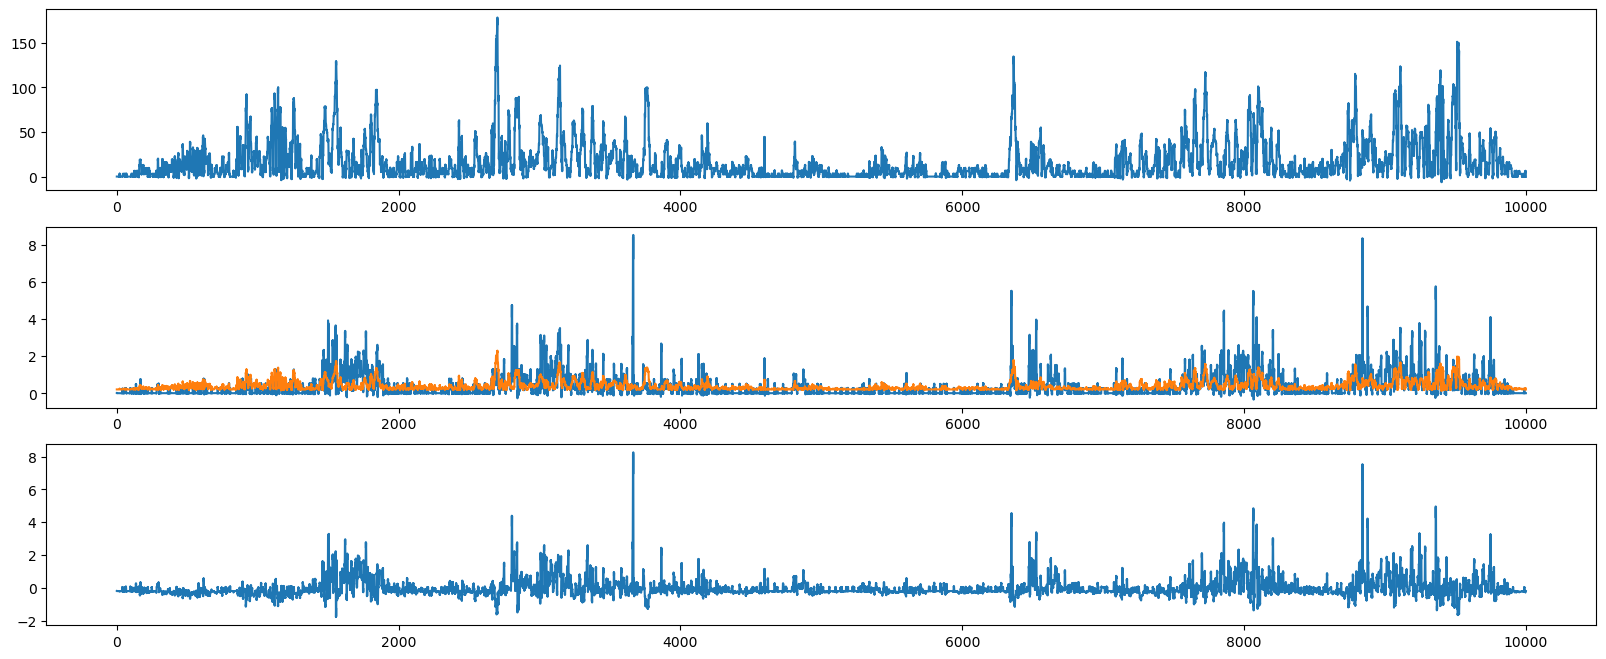

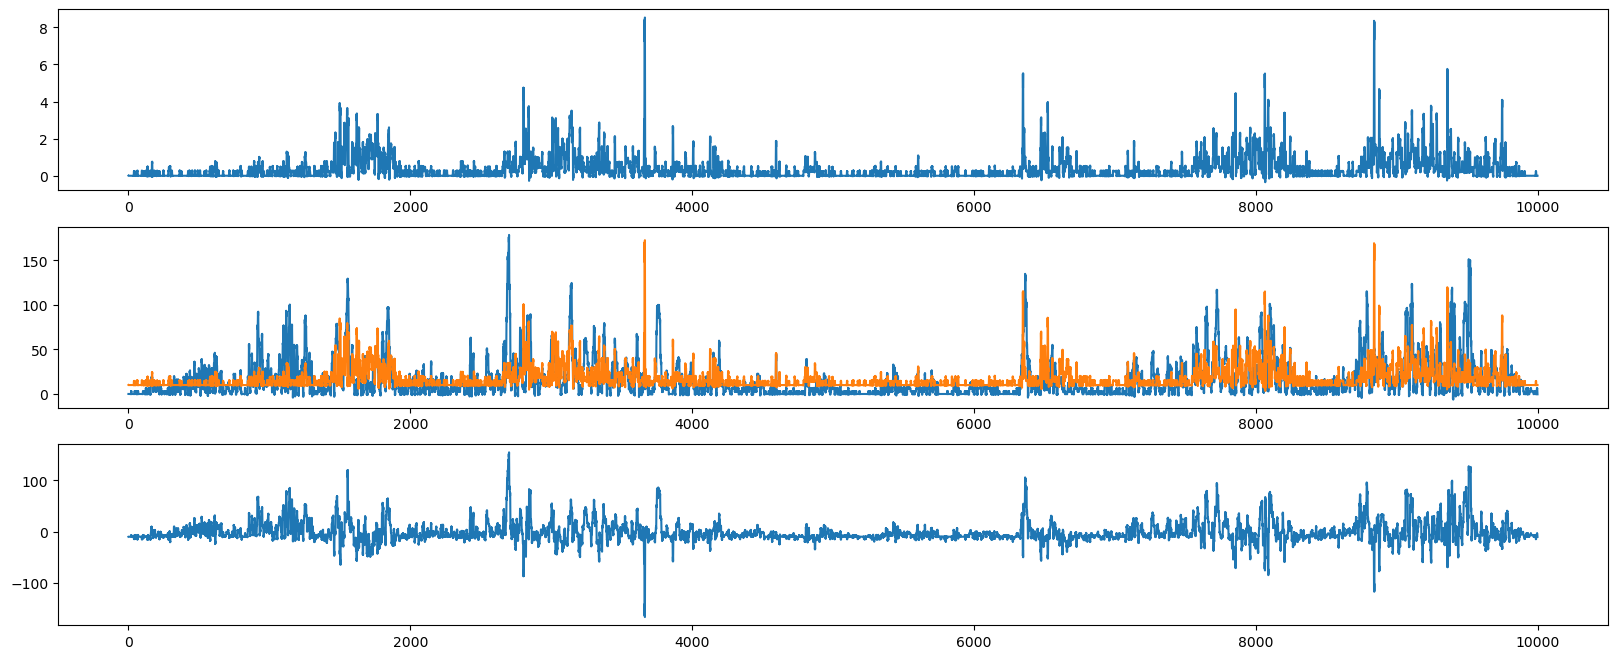

In [53]:
analysis_df = df.copy()

B = glm_utils.bases.raised_cosine(neye = bases_dict['neye'], ncos = bases_dict['ncos'], kpeaks = bases_dict['kpeaks'], b = bases_dict['b'], nbasis = bases_dict['nbasis'])
B = B[-window:]
basis_projection = glm_utils.preprocessing.BasisProjection(B)

analysis_ynames = ["abs_v_fwd","abs_v_ang"]

index = 3
row = analysis_df.iloc[index]
# for index, row in analysis_df.iterrows():

filename = row['filename']
DN_side = row['side']
DN = row['DN']
csv_path = row['abs_file_path']

singleDN_df = load_recording(csv_path=csv_path)

x, ys = get_xy(singleDN_df,analysis_ynames)
X, y_m = glm_utils.preprocessing.time_delay_embedding(x, ys, window_size=window, flatten_inside_window=True, exclude_t0=True)
X_b = basis_projection.transform(X)

residuals = np.zeros_like(y_m)
for iv in range(y_m.shape[1]):
    lr_temp = sklearn.linear_model.Ridge(max_iter=20000)
    lr_temp.fit(y_m[:,[1-iv]], y_m[:,iv])
    y_pred_temp = lr_temp.predict(y_m[:,[1-iv]])
    residuals[:,iv] = y_m[:,iv] - y_pred_temp

    fig, axes = plt.subplots(3,1,figsize=[20,8])
    axes = axes.flatten()
    axes[0].plot(y_m[:10000,[1-iv]])
    axes[1].plot(y_m[:10000,[iv]])
    axes[1].plot(y_pred_temp[:10000])
    axes[2].plot(residuals[:10000,iv])
    plt.show()

iv = 1 # test only the abs_v_ang
X_train, X_test, y_train, y_test = chunked_test_train_split(X_b,residuals,block_size=block_size,n_block_min=n_block_min,test_size=test_size,random_state=random_state)
lr2 = sklearn.linear_model.LassoCV(max_iter=20000)
lr2.fit(X_train, y_train[:,iv])

# Predictions
y_pred = lr2.predict(X_train)
y_pred_test = lr2.predict(X_test)

# Attempt to estimate nonlinearity (last record: ~12% constant value)
nbins = starting_nbins
not_finished = True
while (nbins != 5) and not_finished:
    bin_edges_quantilebased = np.quantile(y_pred, np.linspace(0, 1, nbins + 1))
    try:
        statistic, bin_edges, binnumber = binned_statistic(y_pred, y_train[:,iv]-y_pred, statistic='mean', bins=bin_edges_quantilebased, range=None)
        bin_centers = bin_edges[:-1] + np.median(np.diff(bin_edges)) / 2
        constant_input = False
        not_finished = False
    except ValueError as e:
        if str(e) != 'The smallest edge difference is numerically 0.':
            print("ValueError: ",e)
        else:
            nbins -= 1

if (nbins == 5) and not_finished:
    statistic = [np.nanmean(y_train[:,iv])-np.nanmean(y_pred)]
    bin_centers = [np.nanmean(y_pred)]
    constant_input = True

if np.sum(np.isnan(statistic)) > 0:
    y_pred_test_nl = y_pred_test + np.interp(y_pred_test, bin_centers[~np.isnan(statistic)], statistic[~np.isnan(statistic)])
else:
    y_pred_test_nl = y_pred_test + np.interp(y_pred_test, bin_centers, statistic)

# Scores
r2_train = lr2.score(X_train, y_train[:,iv])
r2_test = lr2.score(X_test, y_test[:,iv]) # equivalent to sklearn.metrics.r2_score(y_test,y_pred_test)
pearsonr_score_linear = pearsonr(y_pred_test, y_test[:,iv]).statistic
if constant_input:
    r2_nl = 0
    pearsonr_score = pearsonr_score_linear
else:
    r2_nl = sklearn.metrics.r2_score(y_test[:,iv],y_pred_test_nl)
    pearsonr_score = pearsonr(y_pred_test_nl, y_test[:,iv]).statistic
# print(f"{filename} {varname} - score (linear): {pearsonr_score_linear:1.2f}, score: {pearsonr_score:1.2f}, train: {r2_train:1.2f}, test: {r2_test:1.2f}, nl: {r2_nl:1.2f} - constant {constant_input}, {nbins} bins")

# Filter
basis_weights = lr2.coef_
estimated_filters = basis_projection.inverse_transform(basis_weights)
estimated_filters = estimated_filters.reshape((-1,window))


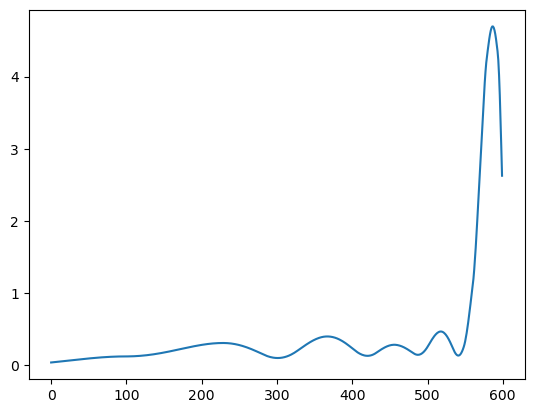

In [56]:
plt.plot(estimated_filters[0,:])
plt.show()

In [6]:
for y_names in (["v_fwd","abs_v_ang"], ["abs_v_fwd","abs_v_ang"]):
    datefolder = f'{results_dir_path}/2025_glms_regressed_{y_names[0]}'

    df_columns = ['filename','pearsonr_score_linear','pearsonr_score','r2_train','r2_test','r2_nl','varname','DN','DN_side','constant','nbins']
    df_all = pd.DataFrame(columns=df_columns)
    for index, row in df.iterrows():
        filename = row['filename']
        DN_side = row['side']
        DN = row['DN']

        for varname in y_names:
            res_file_path = f'{datefolder}/{filename}_{varname}_isplit{isplit}.pkl'
            if os.path.exists(res_file_path):
                # for isplit in range(nsplits):
                with open(res_file_path, 'rb') as handle:
                    temp = pickle.load(handle)
                    temp_df = pd.DataFrame([[filename, temp['pearsonr_score_linear'], temp['pearsonr_score'], temp['r2_train'], temp['r2_test'], temp['r2_nl'], varname, DN, DN_side, temp['constant_input'], temp['nbins']]], columns=df_columns)
                df_all = pd.concat((df_all,temp_df))
    df_all.reset_index(drop=True,inplace=True)
    df_all.to_pickle(f'{datefolder}/df_GLM_results.pkl')
    df_all

C:\Users\apalaci\AppData\Local\Temp\ipykernel_8156\3448510059.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat((df_all,temp_df))
C:\Users\apalaci\AppData\Local\Temp\ipykernel_8156\3448510059.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat((df_all,temp_df))


In [ ]:
for y_names in (["v_fwd","abs_v_ang"], ["abs_v_fwd","abs_v_ang"]):
    datefolder = f'{results_dir_path}/2025_glms_regressed_{y_names[0]}'
    estimated_filters_dict = {}
    for index, row in df.iterrows():
        filename = row['filename']
        DN_side = row['side']
        DN = row['DN']

        estimated_filters_dict[filename] = {}
        for varname in y_names:
            res_file_path = f'{datefolder}/{filename}_{varname}_isplit{isplit}.pkl'
            if os.path.exists(res_file_path):
                estimated_filters_dict[filename][varname] = {}
                estimated_filters_list = []
                with open(res_file_path, 'rb') as handle:
                    temp = pickle.load(handle)
                    estimated_filters_list.append(temp['estimated_filters'][:])
                estimated_filters_dict[filename][varname] = np.vstack(estimated_filters_list)

    with open(f'{datefolder}/GLM_filters.pkl', 'wb') as handle:
        pickle.dump(estimated_filters_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

C:\Users\apalaci\AppData\Local\Temp\ipykernel_16548\1745798506.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(bbox_to_anchor=(1.1, 1.), loc=2, frameon=False)


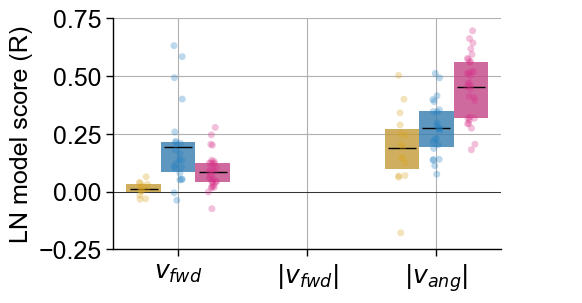

C:\Users\apalaci\AppData\Local\Temp\ipykernel_16548\1745798506.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(bbox_to_anchor=(1.1, 1.), loc=2, frameon=False)


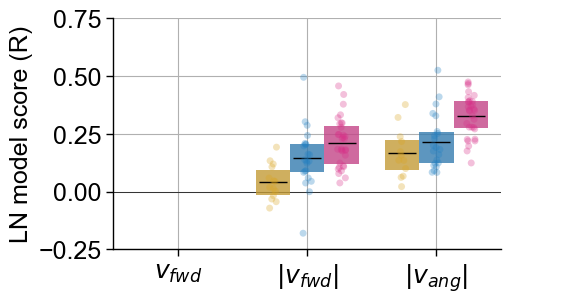

In [8]:
color_perDN_dict = {'MDN':'#207FC3','imposter':'#D83088','DopaMeander':'#D83088','DNp17':'goldenrod','Roadrunner':'SeaGreen'}

for y_names in (["v_fwd","abs_v_ang"], ["abs_v_fwd","abs_v_ang"]):
    datefolder = f'{results_dir_path}/2025_glms_regressed_{y_names[0]}'
    df_plot = pd.read_pickle(f'{datefolder}/df_GLM_results.pkl')
    df_plot['DN_specific'] = df_plot['DN']
    df_plot.loc[df_plot.DN == 'imposter','DN'] = 'DopaMeander'
    plot_variables_list = ['v_fwd','abs_v_fwd','abs_v_ang']
    plot_variables_labels = [r'$v_{fwd}$',r'$|v_{fwd}|$',r'$|v_{ang}|$']
    DN_list_order = ['DNp17','MDN','DopaMeander']

    plt.figure(figsize=[5,3])
    ax=plt.gca()
    ax.axhline(y=0,color='k',lw=0.5)
    # sns.boxplot(data=df_plot, x='varname',y='pearsonr_score',hue='DN', order=plot_variables_list, hue_order=DN_list_order, palette=color_perDN_dict,ax=ax,showfliers=False,whis=0,linewidth=0,legend=False)

    sns.boxplot(data=df_plot, x='varname',y='pearsonr_score',hue='DN', order=plot_variables_list, hue_order=DN_list_order, palette=color_perDN_dict, ax=ax,legend=False, whis=0,showfliers=False,showcaps=False,showmeans=True,boxprops={"edgecolor": "none","alpha": 0.8},meanprops={"marker": "_", "markersize": 20, "markeredgecolor": "k", "markerfacecolor": "k", "linewidth": 5}, medianprops={"visible": False, "color": "k"}) #\meanprops={"marker": "_", "markersize": 20, "color": "k", "linewidth": 5})
    sns.stripplot(data=df_plot, x='varname',y='pearsonr_score',hue='DN', order=plot_variables_list, hue_order=DN_list_order, palette=color_perDN_dict,ax=ax,alpha=0.3,dodge=True,legend=False)

    ax.set_xticks(ax.get_xticks(), plot_variables_labels, rotation=0, ha='center',va='top')
    ax.set_ylim([-0.25,0.75])
    # ax.axhline(y=0.25)
    ax.set_xlabel('')
    ax.grid(True)
    ax.set_ylabel('LN model score (R)')
    ax.legend(bbox_to_anchor=(1.1, 1.), loc=2, frameon=False)
    plt.savefig(f'fig/regressed_{y_names[0]}_scores.pdf', transparent=False, bbox_inches='tight', dpi=300)
    plt.show()

C:\Users\apalaci\AppData\Local\Temp\ipykernel_16548\3741556380.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(bbox_to_anchor=(1.1, 1.), loc=2, frameon=False)


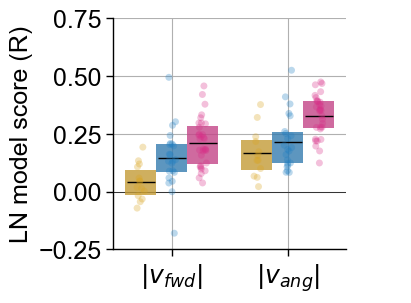

In [ ]:
color_perDN_dict = {'MDN':'#207FC3','imposter':'#D83088','DopaMeander':'#D83088','DNp17':'goldenrod','Roadrunner':'SeaGreen'}



C:\Users\apalaci\AppData\Local\Temp\ipykernel_16548\881347346.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(bbox_to_anchor=(1.1, 1.), loc=2, frameon=False)
C:\Users\apalaci\AppData\Local\Temp\ipykernel_16548\881347346.py:49: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(bbox_to_anchor=(1.1, 1.), loc=2, frameon=False)


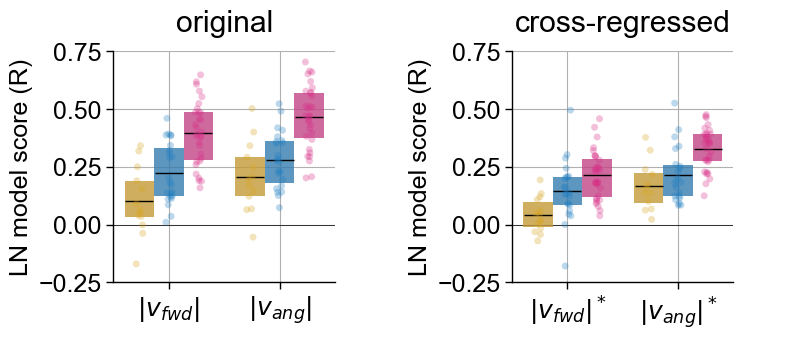

In [18]:
color_perDN_dict = {'MDN':'#207FC3','imposter':'#D83088','DopaMeander':'#D83088','DNp17':'goldenrod','Roadrunner':'SeaGreen'}

y_names = ["abs_v_fwd","abs_v_ang"]
datefolder = f'{results_dir_path}/2025_glms_noZ_fixedbins_linearextrapolation'
df_plot = pd.read_pickle(f'{datefolder}/df_GLM_results.pkl')
df_plot['DN_specific'] = df_plot['DN']
df_plot.loc[df_plot.DN == 'imposter','DN'] = 'DopaMeander'
plot_variables_list = ['abs_v_fwd','abs_v_ang']
plot_variables_labels = [r'$|v_{fwd}|$',r'$|v_{ang}|$']
DN_list_order = ['DNp17','MDN','DopaMeander']

fig, axes = plt.subplots(1,2,figsize=[8,3])

ax=axes[0]
ax.axhline(y=0,color='k',lw=0.5)
# sns.boxplot(data=df_plot, x='varname',y='pearsonr_score',hue='DN', order=plot_variables_list, hue_order=DN_list_order, palette=color_perDN_dict,ax=ax,showfliers=False,whis=0,linewidth=0,legend=False)

sns.boxplot(data=df_plot, x='varname',y='pearsonr_score',hue='DN', order=plot_variables_list, hue_order=DN_list_order, palette=color_perDN_dict, ax=ax,legend=False, whis=0,showfliers=False,showcaps=False,showmeans=True,boxprops={"edgecolor": "none","alpha": 0.8},meanprops={"marker": "_", "markersize": 20, "markeredgecolor": "k", "markerfacecolor": "k", "linewidth": 5}, medianprops={"visible": False, "color": "k"}) #\meanprops={"marker": "_", "markersize": 20, "color": "k", "linewidth": 5})
sns.stripplot(data=df_plot, x='varname',y='pearsonr_score',hue='DN', order=plot_variables_list, hue_order=DN_list_order, palette=color_perDN_dict,ax=ax,alpha=0.3,dodge=True,legend=False)

ax.set_xticks(ax.get_xticks(), plot_variables_labels, rotation=0, ha='center',va='top')
ax.set_ylim([-0.25,0.75])
# ax.axhline(y=0.25)
ax.set_xlabel('')
ax.grid(True)
ax.set_ylabel('LN model score (R)')
ax.legend(bbox_to_anchor=(1.1, 1.), loc=2, frameon=False)
ax.set_title('original', y=1.05)

datefolder = f'{results_dir_path}/2025_glms_regressed_{y_names[0]}'
df_plot = pd.read_pickle(f'{datefolder}/df_GLM_results.pkl')
df_plot['DN_specific'] = df_plot['DN']
df_plot.loc[df_plot.DN == 'imposter','DN'] = 'DopaMeander'
plot_variables_labels = [r'$|v_{fwd}|^*$',r'$|v_{ang}|^*$']

ax=axes[1]
ax.axhline(y=0,color='k',lw=0.5)
# sns.boxplot(data=df_plot, x='varname',y='pearsonr_score',hue='DN', order=plot_variables_list, hue_order=DN_list_order, palette=color_perDN_dict,ax=ax,showfliers=False,whis=0,linewidth=0,legend=False)

sns.boxplot(data=df_plot, x='varname',y='pearsonr_score',hue='DN', order=plot_variables_list, hue_order=DN_list_order, palette=color_perDN_dict, ax=ax,legend=False, whis=0,showfliers=False,showcaps=False,showmeans=True,boxprops={"edgecolor": "none","alpha": 0.8},meanprops={"marker": "_", "markersize": 20, "markeredgecolor": "k", "markerfacecolor": "k", "linewidth": 5}, medianprops={"visible": False, "color": "k"}) #\meanprops={"marker": "_", "markersize": 20, "color": "k", "linewidth": 5})
sns.stripplot(data=df_plot, x='varname',y='pearsonr_score',hue='DN', order=plot_variables_list, hue_order=DN_list_order, palette=color_perDN_dict,ax=ax,alpha=0.3,dodge=True,legend=False)

ax.set_xticks(ax.get_xticks(), plot_variables_labels, rotation=0, ha='center',va='top')
ax.set_ylim([-0.25,0.75])
# ax.axhline(y=0.25)
ax.set_xlabel('')
ax.grid(True)
ax.set_ylabel('LN model score (R)')
ax.legend(bbox_to_anchor=(1.1, 1.), loc=2, frameon=False)
ax.set_title('cross-regressed', y=1.05)
plt.subplots_adjust(hspace=0.5,wspace=0.8)
plt.savefig(f'fig/regressed_comparison_{y_names[0]}_scores.pdf', transparent=False, bbox_inches='tight', dpi=300)
plt.show()

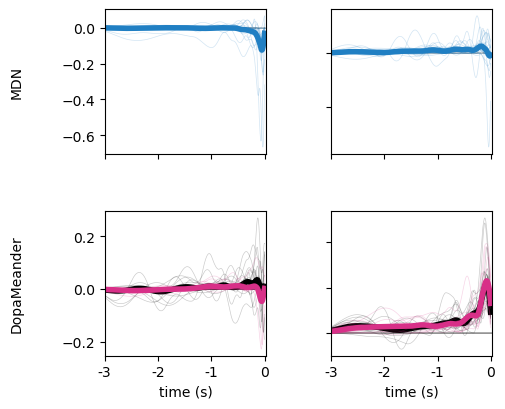

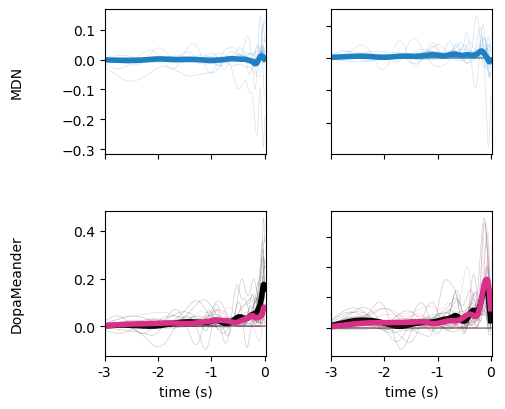

In [13]:
color_perside_dict = {'MDN':'#207FC3','imposter left':'#D83088','imposter right':'k', 'DopaMeander left':'#D83088','DopaMeander right':'k','DNp17':'goldenrod','Roadrunner':'SeaGreen'}
filtered_df = df[~((df.DN == 'imposter') & (df.side == 'undefined'))].copy()
filtered_df['DN_specific'] = filtered_df['DN']
filtered_df.loc[filtered_df.DN == 'imposter','DN'] = 'DopaMeander'

DN_list = ['MDN','DopaMeander']
nrows = len(DN_list)
ncols = 2
subsampled_frequency = int(sample_frequency/bin_width)
window = int(3*subsampled_frequency)
T = np.arange(-window, 0)/subsampled_frequency

for y_names in (["v_fwd","abs_v_ang"], ["abs_v_fwd","abs_v_ang"]):
    variables_list = y_names
    datefolder = f'{results_dir_path}/2025_glms_regressed_{y_names[0]}'

    with open(f'{datefolder}/GLM_filters.pkl', 'rb') as handle:
        estimated_filters_dict = pickle.load(handle)

    fig, axes = plt.subplots(nrows,ncols,figsize=[2.5*ncols,2.25*nrows])

    for iDN, DN_type in enumerate(DN_list):
        for DN_side in filtered_df[(filtered_df.DN == DN_type)].side.unique():
            if (DN_type == 'DopaMeander') and DN_side == 'left':
                main_color = color_perside_dict['DopaMeander left']
            elif (DN_type == 'DopaMeander') and DN_side == 'right':
                main_color = color_perside_dict['DopaMeander right']
            else:
                main_color =color_perDN_dict[DN_type]
            for iv, varname in enumerate(variables_list):
                filename_list = filtered_df[(filtered_df.DN == DN_type)&(filtered_df.side == DN_side)].filename.tolist()
                plot_glm_filter(ax=axes[iDN,iv],estimated_filters_dict=estimated_filters_dict,filename_list=filename_list,varname=varname,T=T,main_color=main_color,with_l2=False,with_individual_traces=True)

    # for irow, ylims in zip(range(2),[(-0.15,0.05),(-0.2,0.3)]):
    #     for ax in axes[irow,:].flatten():
    #         ax.set_ylim(ylims)
    #         ax.set_yticks([ylims[0],0,ylims[1]])
    #         ax.set_yticklabels([ylims[0],0,ylims[1]])

    for iDN, DN_type in enumerate(DN_list):
        axes[iDN,0].set_ylabel(DN_type)
        axes[iDN,0].yaxis.set_label_coords(-0.5, 0.5)
        for ax in axes[iDN,1:].flatten():
            ax.set_ylabel('')
            ax.set_yticklabels([])
    # for iv, varlabel in enumerate(variables_labels):
    #     axes[0,iv].set_title(varlabel,fontsize=20,y=1.15)

    for ax in axes.flatten():
        ax.set_xlim([-3,0.025])
        ax.set_xticks([0,-1,-2,-3])
        ax.set_xticklabels([])
    for ax in axes[-1,:].flatten():
        ax.set_xticklabels([0,-1,-2,-3])
        ax.set_xlabel('time (s)')

    plt.subplots_adjust(hspace=0.4,wspace=0.4)
    # plt.savefig(f'fig/nwg_filters_fwd.pdf', transparent=False, bbox_inches='tight', dpi=300)
    plt.show()